## Testes de Treinamento para o Cluster do H2o

Neste notebook, você encontrará os principais comandos para utilizar o módulo de Python no H2o e rodar o treinamento do AutoML no cluster. Em específico, como:

- Se conectar ao cluster do H2o
- Importar e salvar arquivos
- Treinar um modelo no cluster e recuperar o resultado
- Realizar predição em novos datasets (e conjuntos de testes)
- Checkpointing (a ser implementado)

#### Links Úteis e Referências
- H20 Flow: http://h2o.dev.data.hurb.com/flow/index.html#
- Slack da comunidade: https://app.slack.com/client/TBGG9566N/CBGG95FV0/thread/CBGG95FV0-1603487179.032300
- Módulo de Python H20: https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html#objects-in-this-module
- Tutoriais de AutoML: https://docs.h2o.ai/h2o-tutorials/latest-stable/index.html
- Docs para referência de h2o.automl: https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/automl/autoh2o.html
- Tutoriais flow guide: https://www.youtube.com/playlist?list=PLNtMya54qvOHbBdA1x8FNRSpMBEHmhxr0
- H2o Cheat Sheet: https://ugoproto.github.io/ugo_r_doc/pdf/h2o.pdf
- Metrics Descriptions: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html
- Checkpointing: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/checkpointing-models.html 

### 1) Conexão ao Cluster do H2o

Instalação de pacotes importantes a serem utilizados durante o desenvolvimento:

In [12]:
import h2o
import pandas as pd
import torch
from h2o.automl import H2OAutoML
from sklearn import datasets

Para se conextar ao cluster pela primeira vez, é necessário atualizar o versionamento abaixo:

In [80]:
#!pip install http://h2o-release.s3.amazonaws.com/h2o/rel-zermelo/1/Python/h2o-3.32.0.1-py2.py3-none-any.whl

Com os pacotes carregados, podemos inicializar o módulo de Python do H2O.

**Local**: Para iniciar o h2o localmente, basta rodar h2o.init() sem os parâmetros internos:

In [81]:
# h2o.init() 

**Cluster**: E para conectá-lo ao cluster, podemos inicializá-lo da seguite forma: 

In [13]:
h2o.init(ip='h2o.data.hurb.com', https=False, port=80) 

Checking whether there is an H2O instance running at http://h2o.data.hurb.com:80 . connected.


H2O_cluster_uptime:,10 days 18 hours 58 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.1
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,root
H2O_cluster_total_nodes:,3
H2O_cluster_free_memory:,25.26 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


### 2) Importar , Exportar e Salvar arquivos

- Importar um H2o frame salvo no cluster
- Exportar um arquivo ou um DataFrame/H2oFrame para o cluster
- Importar um arquivo do GCS para um H2o Frame

Listagem de frames disponíveis no cluster: 

In [14]:
h2o.ls()

,key
0,DRF_1_AutoML_20201111_222757
1,DRF_1_AutoML_20201127_142221
2,DRF_1_AutoML_20201127_152749
3,DRF_1_AutoML_20201127_162052
4,DRF_1_AutoML_20201127_163547
...,...
6822,tutorial_training_flow_1@@SalePrice
6823,tutorial_training_flow_1_eventlog
6824,tutorial_training_flow_1_leaderboard
6825,upload_a385ee30b7997faef3d34e9a98c24983


Importar um H2o frame salvo no cluster para uma variável local:

In [15]:
boston_data = h2o.get_frame("boston_housing.hex")

boston_data.head(3)

CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


#### Exportar um arquivo ou um DataFrame/H2oFrame para o cluster

Até o momento de escrita deste notebook, não encontrei comandos para exportar diretamente variáveis para o cluster pelo módulo de python (não possuímos ainda um HDFS do time). Contudo, é possível salvar o arquivo em questão no GoogleCloudStorage ou locamente e depois importar o arquivo pela interface do Flow:

Por exemplo:

In [16]:
nome_do_arquivo = 'tutorial'
path = 'gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/{}.csv'.format(nome_do_arquivo)

In [17]:
df =  pd.DataFrame(['A', 'B'], columns = ['letters'])

# Criando um H2o Frame a partir de um DataFrame. É possível criar um h2o a partir de várias estruturas em python.
hf = h2o.H2OFrame(python_obj=df)

# Exportar o arquivo para o GCS
h2o.export_file(hf, path, force = True)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%


Depois, só será necessário fazer o upload deste arquivo pela interface do H2o Flow, digitando o path!

#### Importar um arquivo do GCS para um H2o Frame

In [18]:
hf_2 = h2o.import_file(path, header = 1)

Parse progress: |█████████████████████████████████████████████████████████| 100%


### 3) Treinamento usando o módulo Python


É possível deixar o treinamento acontecendo no cluster mesmo sem a máquina local estar conectada ao cluster durante todo o processo. Para isso, será necessário especificar o o parâmetro ***project_name*** ao declarar o objeto de AutoML e, ao final do treinamento, recuperar o objeto através do comando ***h2o.automl.get_automl(project_name)***. Veremos um exemplo abaixo:

Inicializando os frames e variáveis necessárias para o modelo, e fazendo o split em train e test...

In [19]:
train_boston, test_boston = boston_data.split_frame(ratios=[.75])

x = train_boston.columns
y = 'target'
x.remove(y)

Ao declarar o objeto da classe H2OAutoML é necessário especificar o project_name para salvá-lo e recuperá-lo 
no cluster

In [21]:
aml_boston = H2OAutoML(seed=1,
                       project_name = 'boston_tutorial_talk',
                       max_models = 10)

aml_boston.train(x=x,  # colunas das variáveis de entrada no frame
                 y=y,  # coluna que representa a variável de saída do frame
                 training_frame=train_boston,
                 leaderboard_frame=test_boston)

AutoML progress: |████████████████████████████████████████████████████████| 100%


#### Caso o tempo de treinamento seja curto...

Quando o modelo tiver um tempo de treinamento rápido, podemos ver seus resultados localmente
Para checar os resultados, podemos fazer: 

In [25]:
lb = aml_boston.leaderboard
lb.head(10)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_1_AutoML_20201204_141448,9.19389,3.03214,9.19389,2.15068,0.152648
StackedEnsemble_BestOfFamily_AutoML_20201204_141448,10.2093,3.19521,10.2093,1.97525,0.139849
XGBoost_3_AutoML_20201204_141448,10.483,3.23774,10.483,2.10178,0.146978
StackedEnsemble_AllModels_AutoML_20201204_141448,10.6855,3.26886,10.6855,2.01322,0.141487
GBM_1_AutoML_20201204_141448,10.791,3.28497,10.791,2.04145,0.154882
XGBoost_1_AutoML_20201204_141448,11.4758,3.38759,11.4758,2.4177,0.162281
GBM_3_AutoML_20201204_141448,11.9672,3.45936,11.9672,2.131,0.154162
GBM_2_AutoML_20201204_141448,13.2064,3.63407,13.2064,2.22938,0.160491
GBM_4_AutoML_20201204_141448,13.6611,3.69609,13.6611,2.09313,0.158071
XGBoost_2_AutoML_20201204_141448,14.455,3.80197,14.455,2.37442,0.1608


#### Caso o tempo de treinamento seja muito longo...

Caso não possamos esperar o treinamento finalizar localmente e precisemos encerrar o processo local do python, o treinamento continua rodando no cluster, mas os resultados finais não serão salvos no GCS (caso estejam numa célula de notebook). Podemos fazer isso recuperando o objeto H2oAutoModel do cluster especificado acima através do parâmetro ***project_name***. Para isso, podemos fazer:

In [27]:
aml = h2o.automl.get_automl("boston_tutorial_talk")

Verificar o objeto recuperado...

In [28]:
lb = aml.leaderboard
lb.head(3)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
DRF_1_AutoML_20201204_141448,9.19389,3.03214,9.19389,2.15068,0.152648
StackedEnsemble_BestOfFamily_AutoML_20201204_141448,10.2093,3.19521,10.2093,1.97525,0.139849
XGBoost_3_AutoML_20201204_141448,10.483,3.23774,10.483,2.10178,0.146978


**Verificar tempo de treinamento e tempo de predição**

In [29]:
lb_boston = h2o.automl.get_leaderboard(aml_boston, extra_columns = 'ALL')
lb_boston.head(10)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
DRF_1_AutoML_20201204_141448,9.19389,3.03214,9.19389,2.15068,0.152648,2424,0.105466
StackedEnsemble_BestOfFamily_AutoML_20201204_141448,10.2093,3.19521,10.2093,1.97525,0.139849,388,0.29998
XGBoost_3_AutoML_20201204_141448,10.483,3.23774,10.483,2.10178,0.146978,244,0.092767
StackedEnsemble_AllModels_AutoML_20201204_141448,10.6855,3.26886,10.6855,2.01322,0.141487,415,0.477318
GBM_1_AutoML_20201204_141448,10.791,3.28497,10.791,2.04145,0.154882,1803,0.094228
XGBoost_1_AutoML_20201204_141448,11.4758,3.38759,11.4758,2.4177,0.162281,277,0.093918
GBM_3_AutoML_20201204_141448,11.9672,3.45936,11.9672,2.131,0.154162,2601,0.07218
GBM_2_AutoML_20201204_141448,13.2064,3.63407,13.2064,2.22938,0.160491,2441,0.085291
GBM_4_AutoML_20201204_141448,13.6611,3.69609,13.6611,2.09313,0.158071,2503,0.088552
XGBoost_2_AutoML_20201204_141448,14.455,3.80197,14.455,2.37442,0.1608,219,0.090591


In [30]:
lb.nrow

12

***Salvar o Modelo***

Depois de completo o treinamento, podelos salvar o modelo. É possível salvar o(s) modelo(s) escolhido(s) em dois formatos:

- *Binário*: através da função *h2o.save_model*. Contudo, os arquivos em binário dos modelos só serão suportados caso lidos pela mesma versão do h2o em que foram treinados. Para predição e uso futuro, é aconselhável salvar no formato MOJO.

- *MOJO*: através do método *h2o.model.save_mojo*. Ao contrário do formato binário, ele independe de versão. 

In [31]:
# Binário
h2o.save_model(aml.leader, path = 'gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/tutorial_training', force = True)

# Mojo
aml.leader.save_mojo('gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/tutorial_mojo')

'gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/tutorial_mojo/DRF_1_AutoML_20201204_141448.zip'

#### Caso se deseje salvar um modelo específico ao invés do líder:

Podemos converter o H2o para um DataFrame e acessar todos os modelos treinados:

In [32]:
aml_pd = aml.leaderboard.as_data_frame(use_pandas=True)

In [33]:
aml_pd['model_id'][5]

'XGBoost_1_AutoML_20201204_141448'

Assim, podemos salvar os modelos como vimos antes: 

In [34]:
model = h2o.get_model(aml_pd['model_id'][5])

# Binário
h2o.save_model(model, path = 'gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/model_5', force = True)

# MOJO
model.save_mojo('gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/tutorial_mojo', force = True)

'gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/tutorial_mojo/XGBoost_1_AutoML_20201204_141448.zip'

**Carregar modelos pelo GCS**

Depois de salvos, podemos também agora carregar os modelos diretamente do GCS em outra inicialização:

In [35]:
%%capture
# Binário
model = h2o.load_model('gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/tutorial_training/StackedEnsemble_AllModels_AutoML_20201111_222757')

# MOJO
model_mojo = h2o.import_mojo('gs://hurb_transient/INTERNAL/DATA_SCIENCE/tutorials/tutorial_mojo/StackedEnsemble_AllModels_AutoML_20201111_222757.zip')

### 4) Entendendo e Explorando os resultados do treinamento

Para ver a performance dos modelos durante o treinamento nos datasets de treino e de validação cruzada, é possível fazer:

In [36]:
aml.leader

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20201204_141448


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,41.0,41.0,118829.0,13.0,20.0,16.878048,214.0,243.0,226.2683




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 11.49238136452486
RMSE: 3.390041498938451
MAE: 2.3130637251024067
RMSLE: 0.15398823057180547
Mean Residual Deviance: 11.49238136452486

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 11.73626000771783
RMSE: 3.4258225300966525
MAE: 2.2783079346036237
RMSLE: 0.14839043706683883
Mean Residual Deviance: 11.73626000771783

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,2.2769008,0.28002295,2.3194826,2.3676064,2.668487,1.9353288,2.093599
1,mean_residual_deviance,11.7153,4.5879436,9.82967,15.358834,17.77545,7.606815,8.005733
2,mse,11.7153,4.5879436,9.82967,15.358834,17.77545,7.606815,8.005733
3,r2,0.85679644,0.0615511,0.88001883,0.7709539,0.81621146,0.9200852,0.89671284
4,residual_deviance,11.7153,4.5879436,9.82967,15.358834,17.77545,7.606815,8.005733
5,rmse,3.371569,0.659377,3.1352303,3.919035,4.216094,2.7580454,2.8294404
6,rmsle,0.14730982,0.019109584,0.1422642,0.16425173,0.17022891,0.13280725,0.12699704



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-12-04 14:15:00,3.894 sec,0.0,NaN,NaN,NaN
1,,2020-12-04 14:15:00,4.201 sec,5.0,4.483202,3.121105,20.099104
2,,2020-12-04 14:15:01,4.472 sec,10.0,4.106274,2.792032,16.861489
3,,2020-12-04 14:15:01,4.750 sec,15.0,3.773670,2.559330,14.240583
4,,2020-12-04 14:15:01,5.049 sec,20.0,3.701691,2.490566,13.702517
5,,2020-12-04 14:15:02,5.357 sec,25.0,3.615892,2.447255,13.074672
6,,2020-12-04 14:15:02,5.661 sec,30.0,3.542787,2.396239,12.551337
7,,2020-12-04 14:15:02,5.943 sec,35.0,3.519158,2.353159,12.384475
8,,2020-12-04 14:15:02,6.227 sec,40.0,3.452637,2.333222,11.920705
9,,2020-12-04 14:15:02,6.291 sec,41.0,3.390041,2.313064,11.492381



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,LSTAT,291761.968750,1.000000,0.300413
1,RM,263071.593750,0.901665,0.270872
2,INDUS,83380.882812,0.285784,0.085853
3,PTRATIO,75256.156250,0.257937,0.077488
4,DIS,63496.410156,0.217631,0.065379
5,CRIM,47474.425781,0.162716,0.048882
6,NOX,41722.843750,0.143003,0.042960
7,AGE,34721.414062,0.119006,0.035751
8,B,29373.794922,0.100677,0.030245
9,TAX,14743.446289,0.050532,0.015181


In [100]:
%%capture
model

**Parâmetros**

In [37]:
model.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_AutoML_20201111_222757',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_AutoML_20201111_222757'},
  'input': None},
 'training_frame': {'default': None, 'actual': None, 'input': None},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'SalePrice',
   'is_member_of_frames': None},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'ColSpecifierV3',
    'schema_type': 'VecSpecifier'},
   'column_name': 'SalePrice',
   'is_member_of_frames': None}},
 'validation_frame': {'default': None, 'actual': None, 'input': None},
 'blending_frame': {'default': None, 'actual': None, 'input': None},
 'base_models': {'default': [],
  'actual': [{'__meta': {'schema_ve

**Gráficos descritivos do modelo**

Uma feature interessante é o h2o.explain(), que oferece várias visualizações dos modelos. 

*The main functions, h2o.explain() (global explanation) and h2o.explain_row() (local explanation) work for individual H2O models, as well a list of models or an H2O AutoML object.* A documentação de como personalizar os gráficos e procurar os insigjts desejados pode ser obtida através do seguinte link: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

Ele oferce gráficos como *Variable Importance*, *SHAP*, dentre outros.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20201203_225254,6.35467,2.52085,6.35467,1.7467,0.12057,296,0.433865
StackedEnsemble_BestOfFamily_AutoML_20201203_225254,6.55405,2.56009,6.55405,1.7661,0.121689,255,0.259458
XGBoost_3_AutoML_20201203_225254,7.82621,2.79754,7.82621,2.06259,0.139629,155,0.068988
XGBoost_1_AutoML_20201203_225254,7.8506,2.80189,7.8506,2.17359,0.151305,161,0.087368
GBM_4_AutoML_20201203_225254,8.55437,2.92479,8.55437,2.0365,0.13933,1745,0.078168
DRF_1_AutoML_20201203_225254,8.57845,2.9289,8.57845,2.02993,0.142188,2063,0.068661
GBM_2_AutoML_20201203_225254,8.69848,2.94932,8.69848,1.99513,0.132315,1473,0.076989
GBM_1_AutoML_20201203_225254,8.97325,2.99554,8.97325,2.0284,0.139509,1522,0.071897
GBM_3_AutoML_20201203_225254,9.03357,3.00559,9.03357,2.08751,0.141248,1543,0.071228
XGBoost_2_AutoML_20201203_225254,9.38088,3.06282,9.38088,2.28432,0.157727,176,0.078426


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

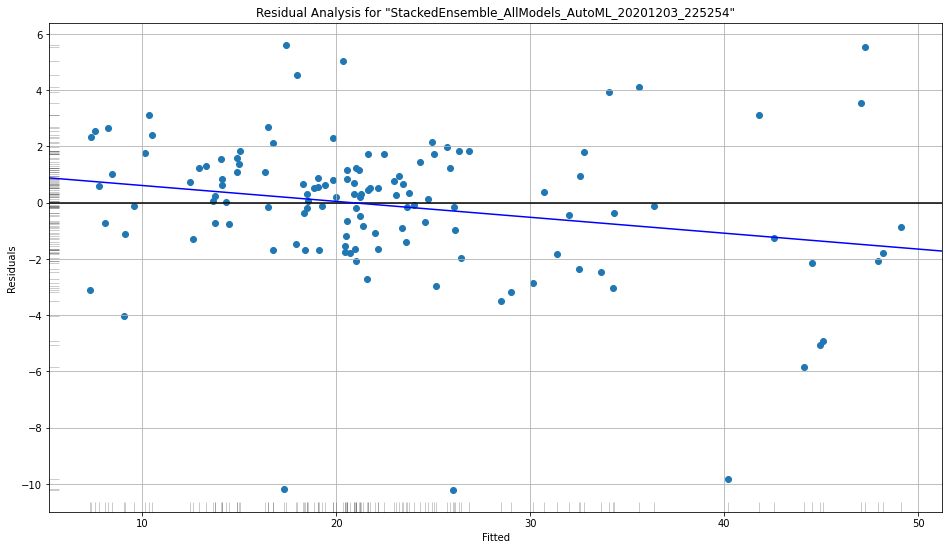

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

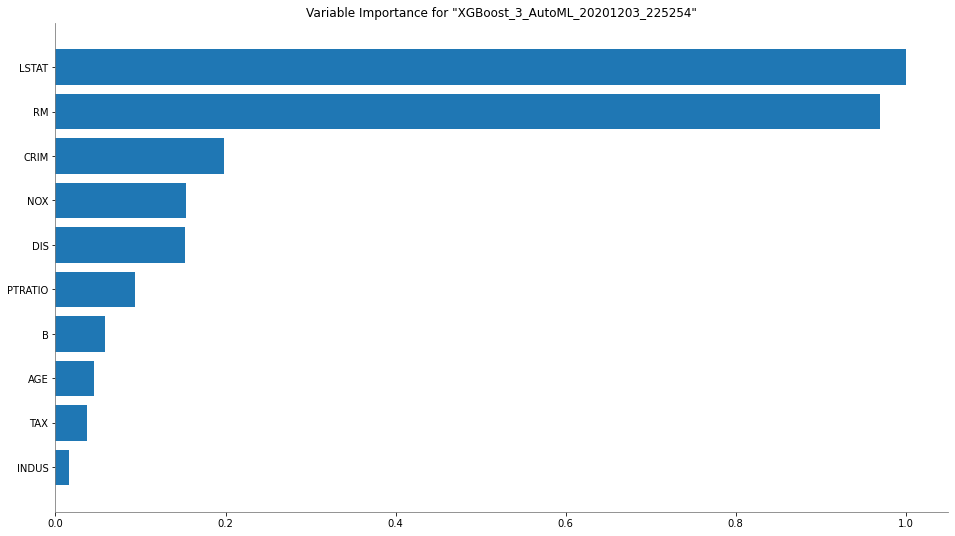

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

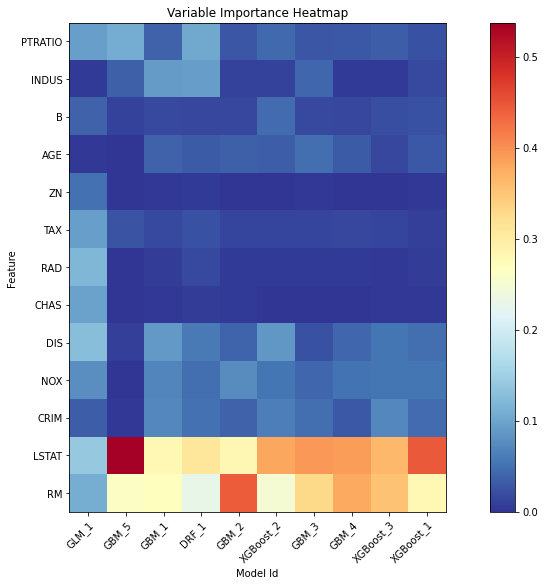

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

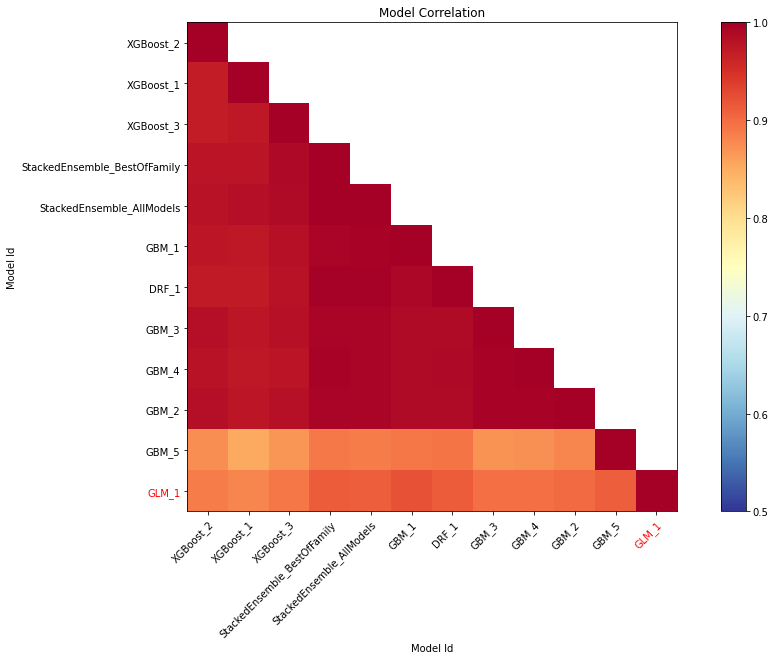

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

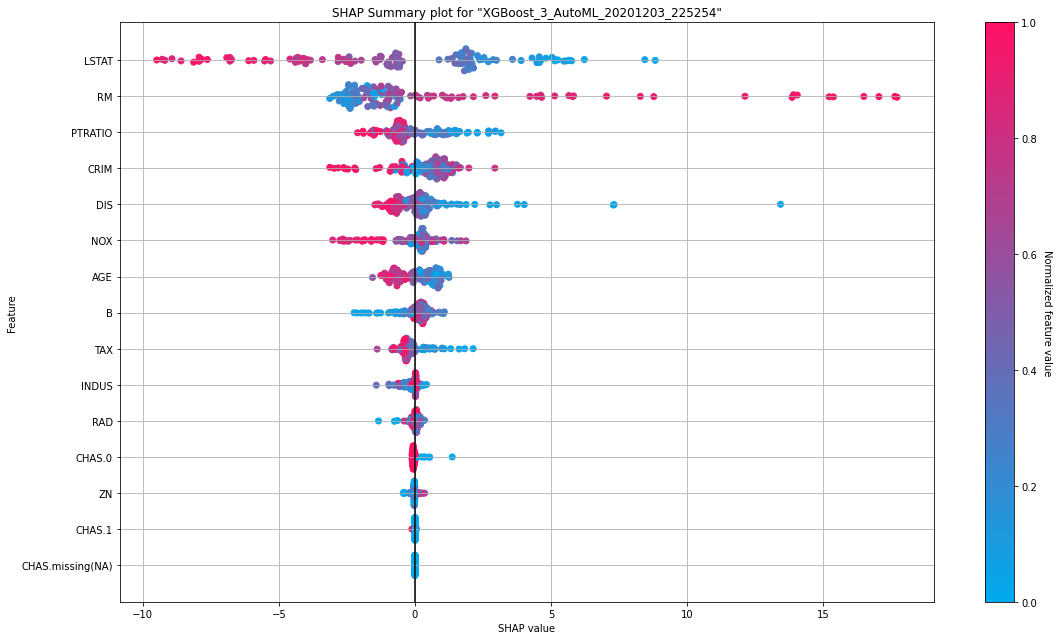

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

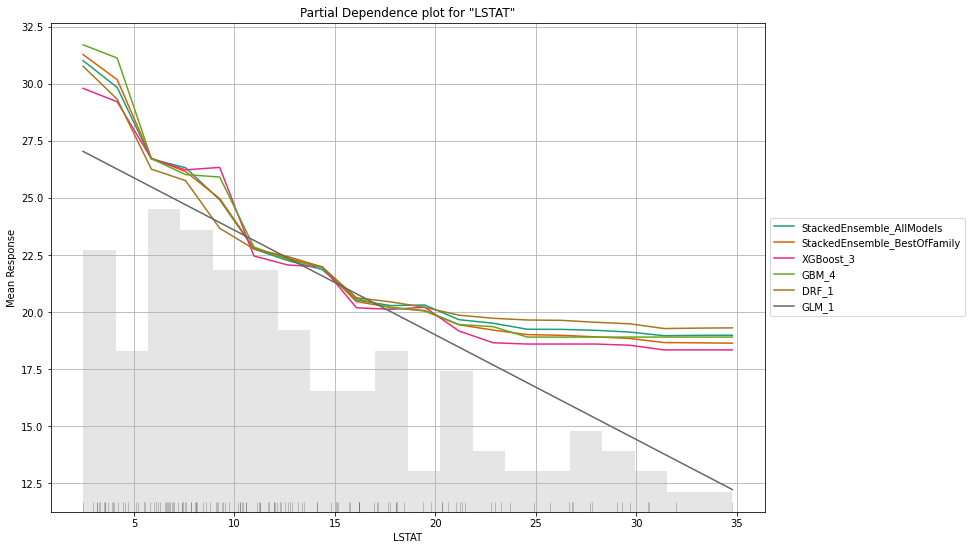

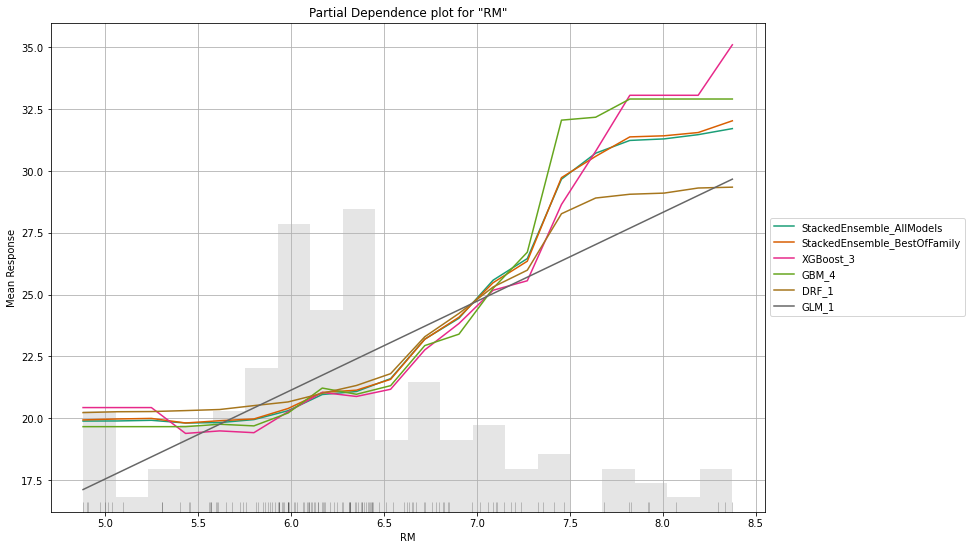

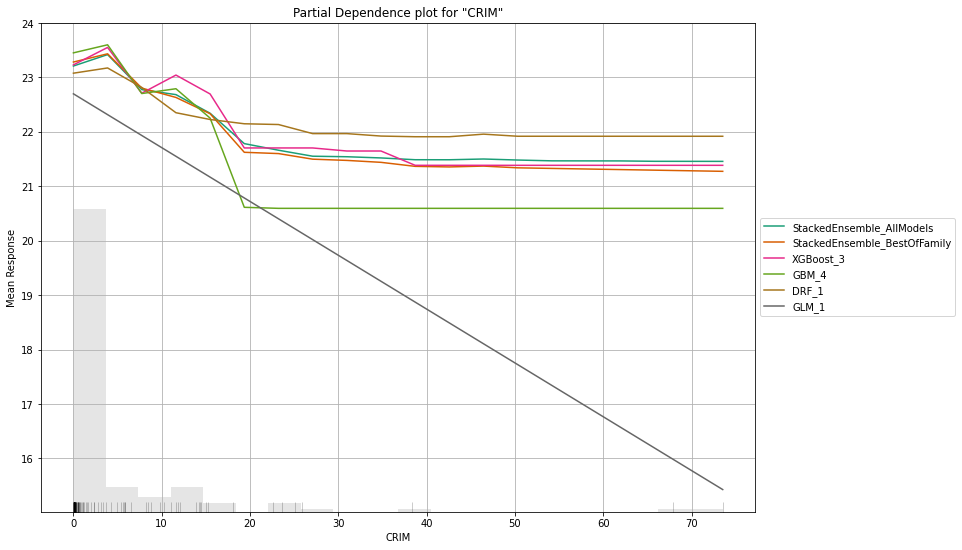

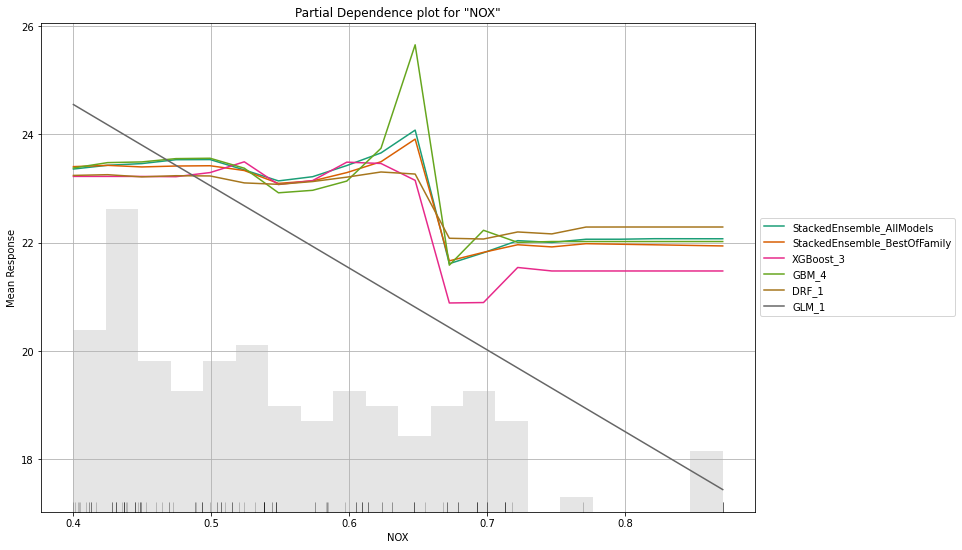

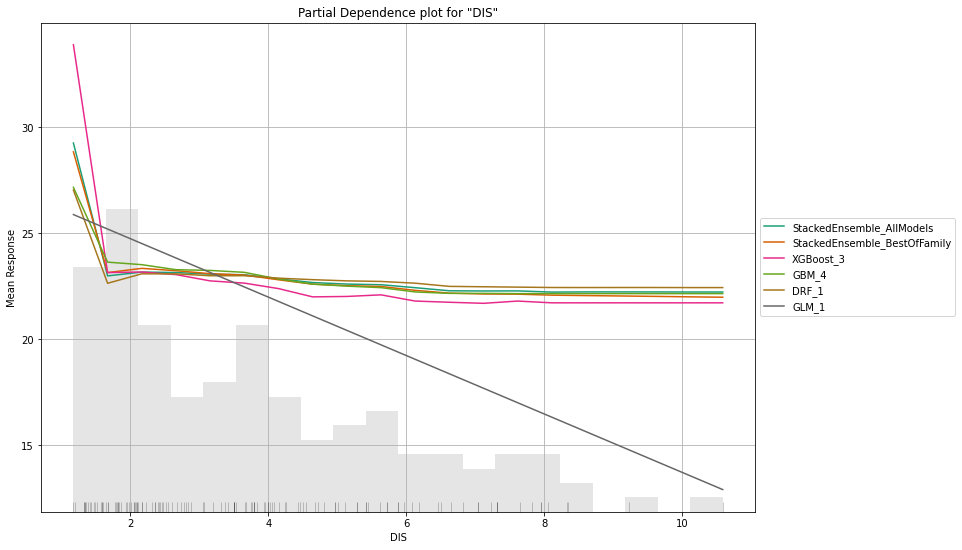

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

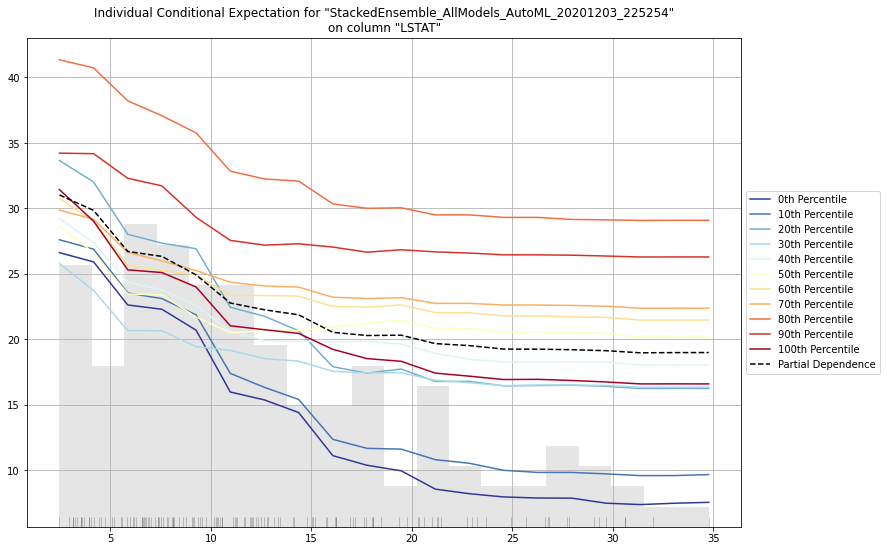

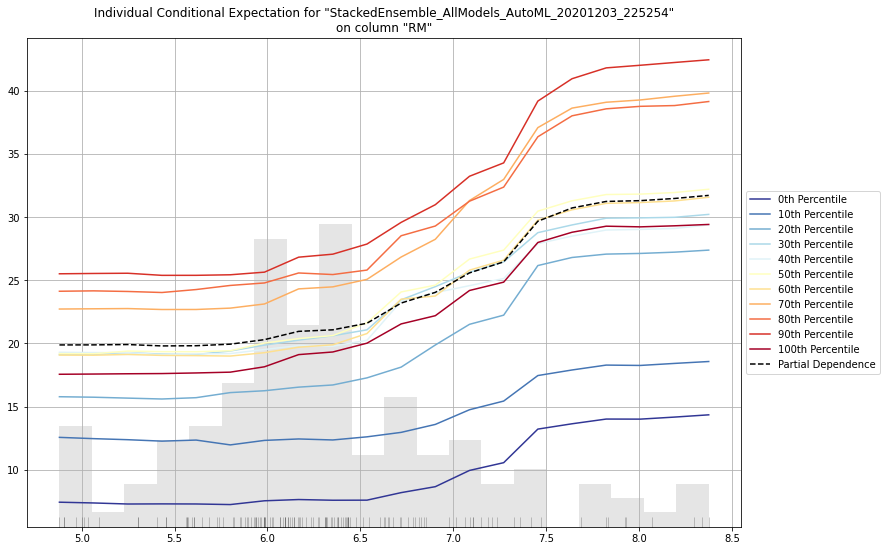

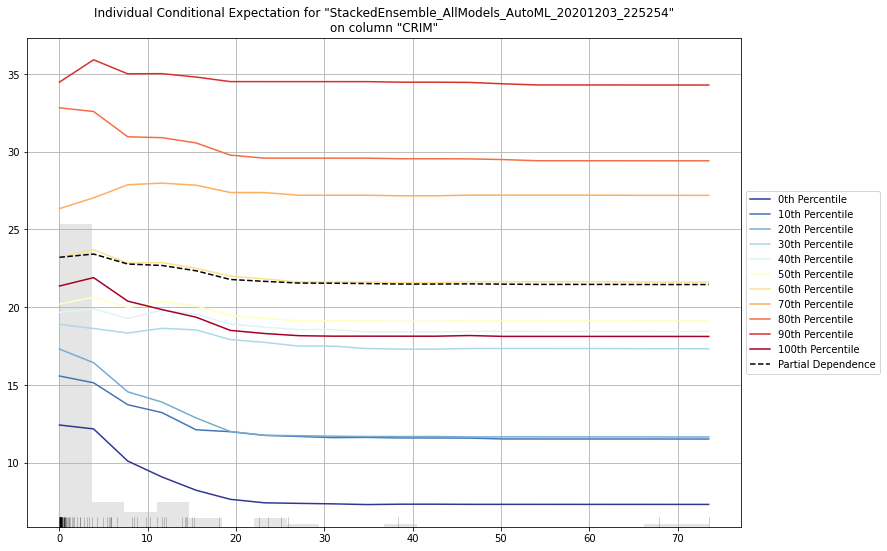

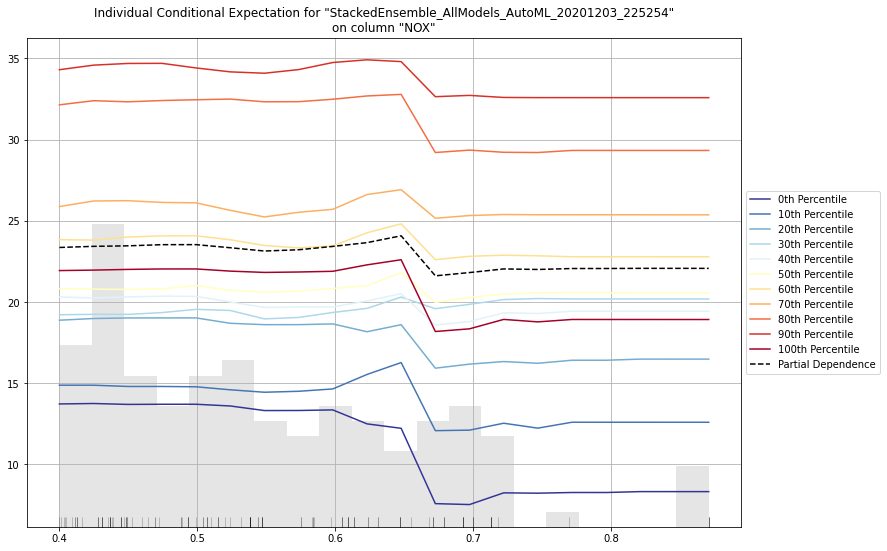

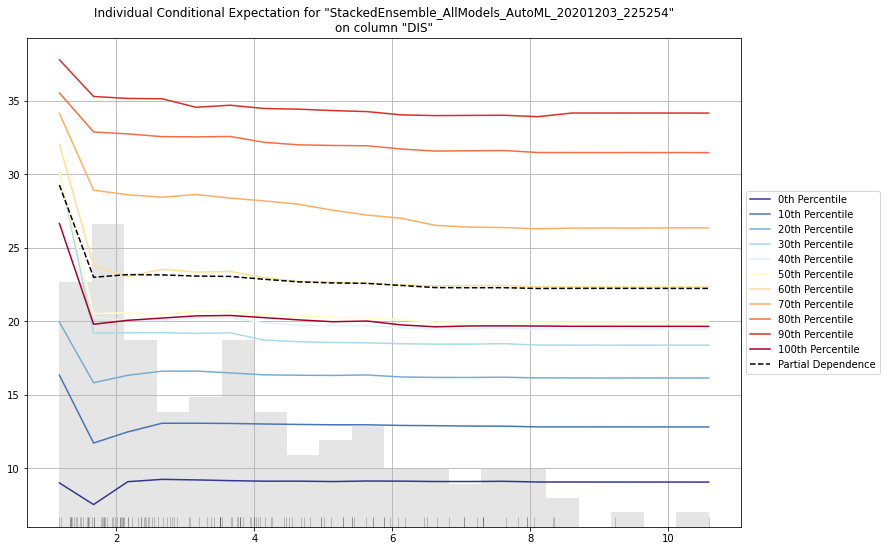

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms
StackedEnsemble_AllModels_AutoML_20201203_225254,6.35467,2.52085,6.35467,1.7467,0.12057,296,0.433865
StackedEnsemble_BestOfFamily_AutoML_20201203_225254,6.55405,2.56009,6.55405,1.7661,0.121689,255,0.259458
XGBoost_3_AutoML_20201203_225254,7.82621,2.79754,7.82621,2.06259,0.139629,155,0.068988
XGBoost_1_AutoML_20201203_225254,7.8506,2.80189,7.8506,2.17359,0.151305,161,0.087368
GBM_4_AutoML_20201203_225254,8.55437,2.92479,8.55437,2.0365,0.13933,1745,0.078168
DRF_1_AutoML_20201203_225254,8.57845,2.9289,8.57845,2.02993,0.142188,2063,0.068661
GBM_2_AutoML_20201203_225254,8.69848,2.94932,8.69848,1.99513,0.132315,1473,0.076989
GBM_1_AutoML_20201203_225254,8.97325,2.99554,8.97325,2.0284,0.139509,1522,0.071897
GBM_3_AutoML_20201203_225254,9.03357,3.00559,9.03357,2.08751,0.141248,1543,0.071228
XGBoost_2_AutoML_20201203_225254,9.38088,3.06282,9.38088,2.28432,0.157727,176,0.078426


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

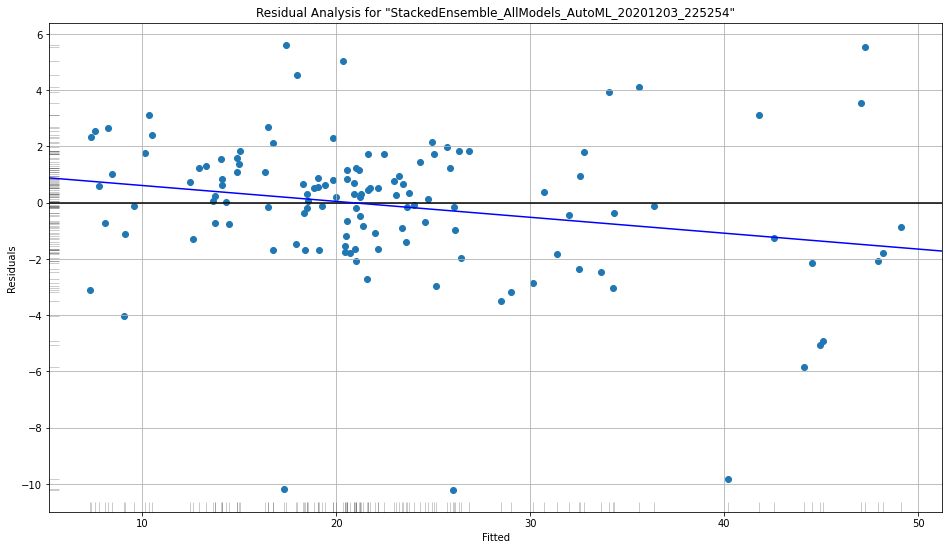

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

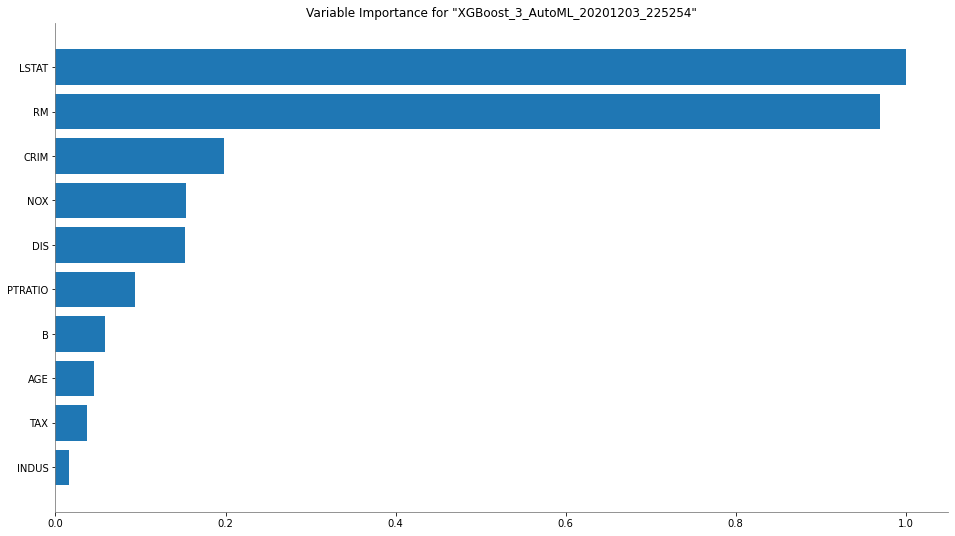

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

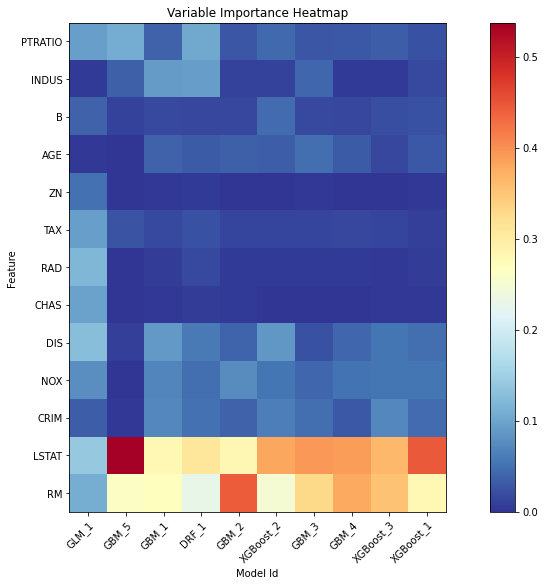

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

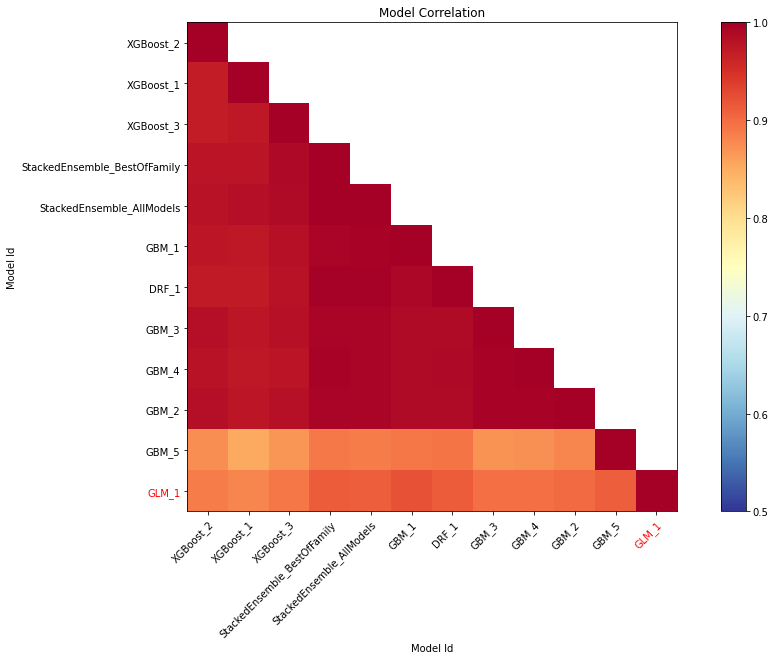

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

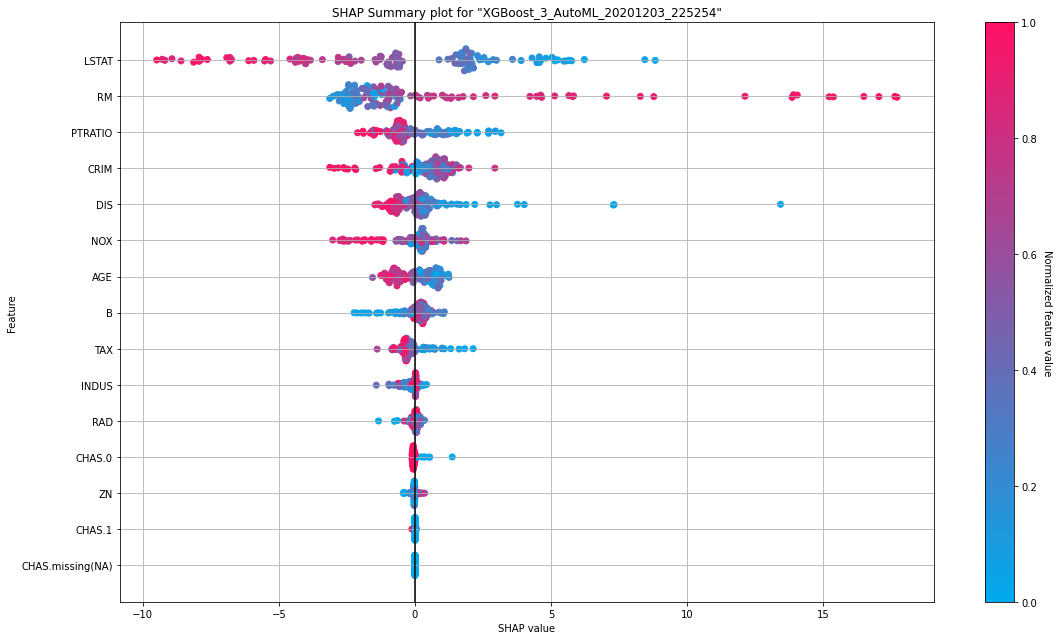

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

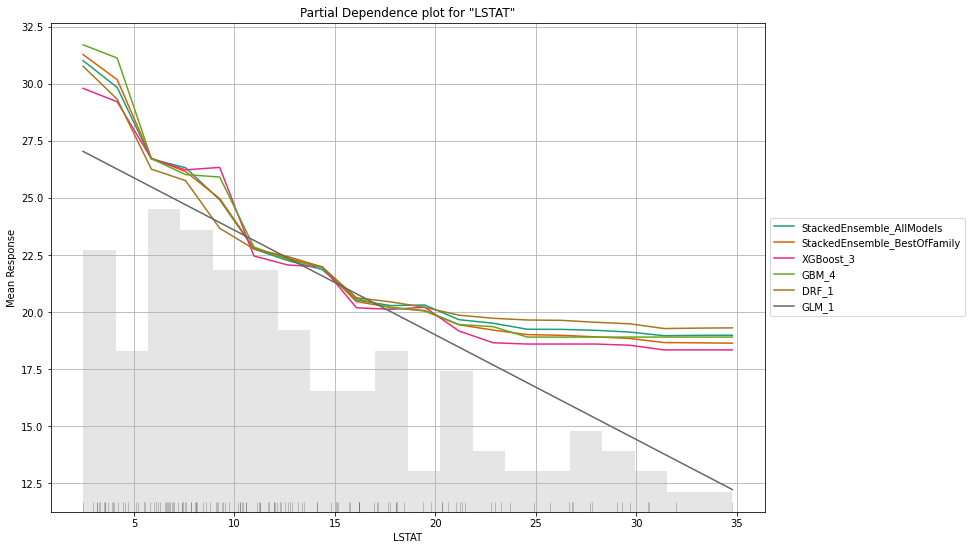

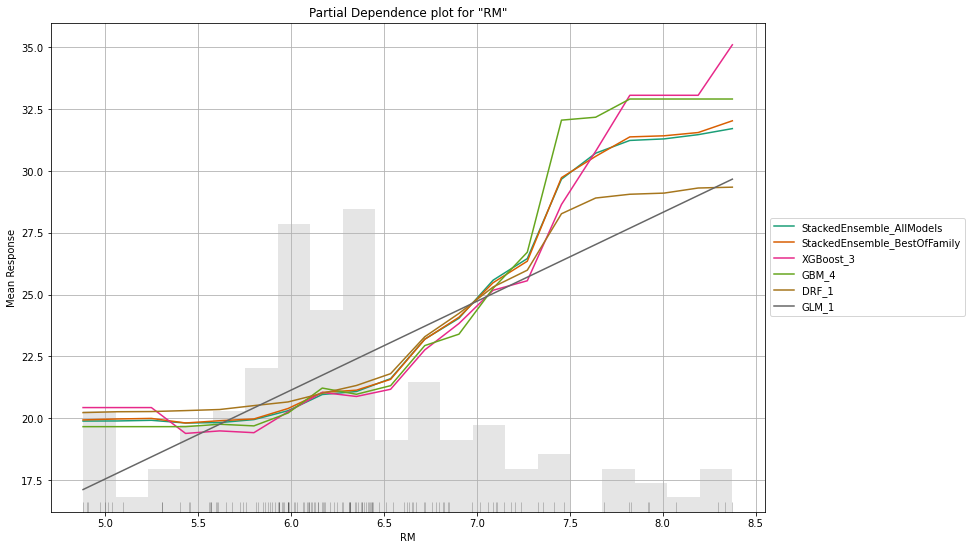

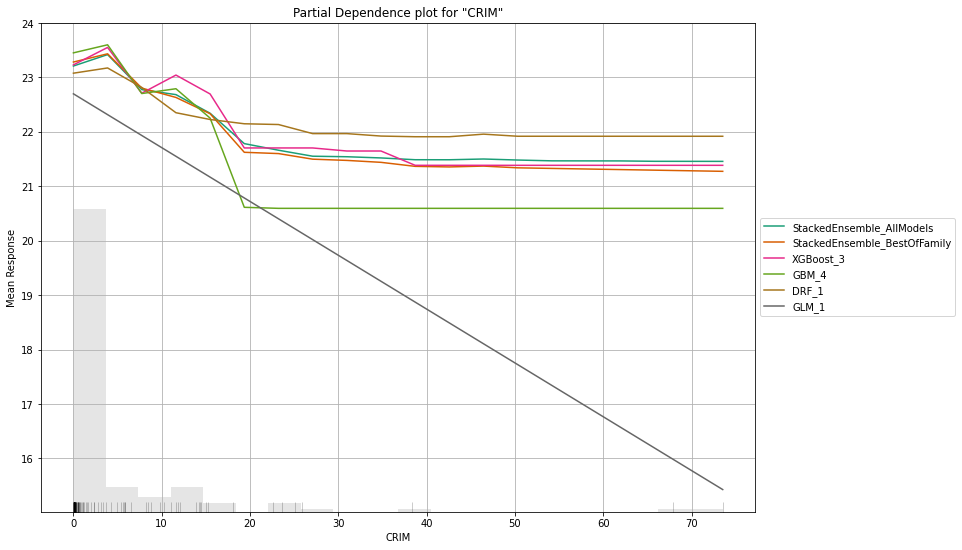

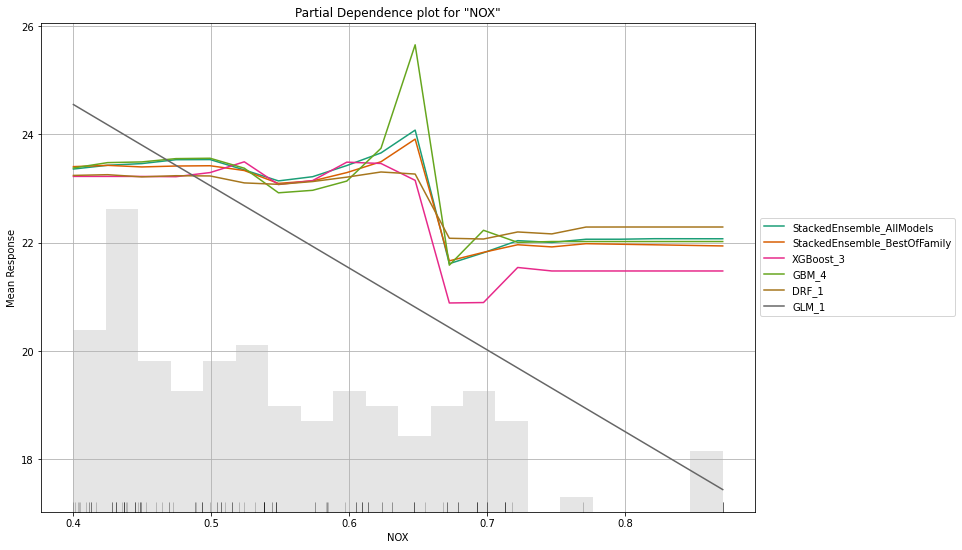

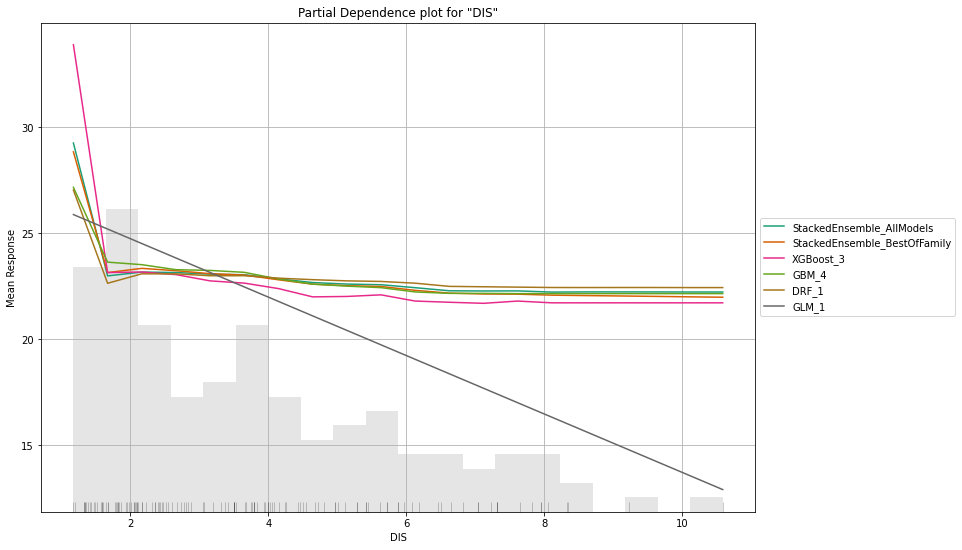

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

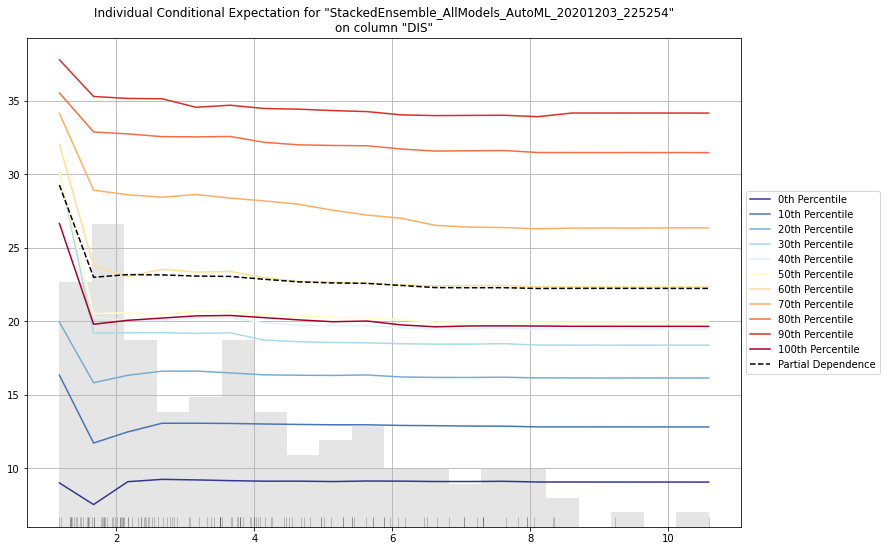

In [103]:
aml.explain(test_boston)

**Explorando os Ensembles**

O AutoML do H2O funciona em duas partes: 

1) Primeiro, ele treina uma base de modelos pré-selecionados, de diferentes famílias, chamados ***Base Models***. Nesta etapa, o h2o também faz uma busca por sets diferentes de hiperparâmetros dentre os modelos base. 

2) Depois, ele cria dois ***Stacked Ensembles*** a partir dos modelos bases. 
- Um considerando o conjunto de todos os modelos base;
- E outro considerando o conjunto dos melhores modelos de cada família. 

Normalmente, os Ensembles são os modelos mais performáticos do AutoML. Para explorá-los, é possível ter acesso aos Stacked Ensembles e algumas de suas propriedades, da seguinte forma:

In [38]:
ensemble_name = "StackedEnsemble_AllModels"
#ensemble_name = "StackedEnsemble_BestOfFamily"

In [39]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
se = h2o.get_model([mid for mid in model_ids if ensemble_name in mid][0])
metalearner = h2o.get_model(se.metalearner().model_id)

A partir da obtenção do metalearner e do model_id dos ensembles, é possível chamar suas propriedades, disponíveis em x. Uma das opções é verificar o quanto cada modelo está constribuindo para o Ensemble, plotando o gráfico de nome *"Standardized Coef. Maginitudes"*

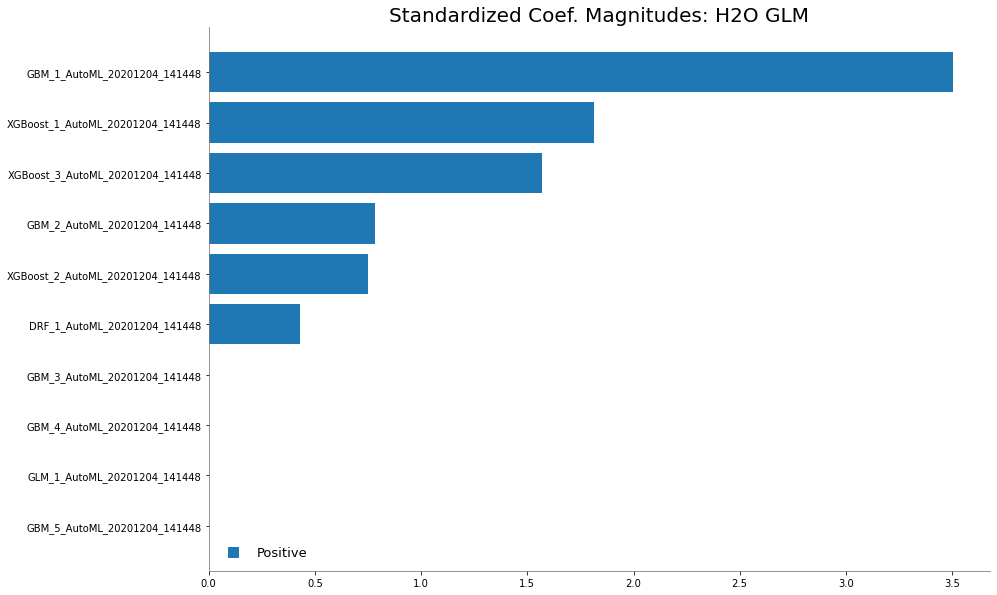

In [40]:
%matplotlib inline
metalearner.std_coef_plot()

### 5) Predição e Perfomance utilizando os modelos já treinados

Depois que já tivermos um modelo escolhido, ou um grupo de modelos escolhidos, podemos querer testar o seu desempenho em um dataset de teste. Para isso, podemos fazer:

**Performance em um dataset de teste**

In [41]:
model = aml.leader

perf = model.model_performance(test_boston)
perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 9.193885474764397
RMSE: 3.0321420604523786
MAE: 2.1506790988012003
RMSLE: 0.15264847117813743
Mean Residual Deviance: 9.193885474764397


In [43]:
model.r2()

0.8633173404634122

Caso seja necessário consultar outras métricas específicas (em especial no MOJO em que algumas não vem no resumo), é possível consultá-las pelos seus métodos prórios, documentados no seguinte link: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html

**Predição de um modelo treinado**

In [45]:
house_price = model.predict(test_boston.head(3))
house_price

drf prediction progress: |████████████████████████████████████████████████| 100%


predict
25.4476
20.5927
19.0415


### 6) Checkpointing

Durante nossas aplicações, é possível que queiramos retreinar um modelo com novos dados. No H2O, podemos usar o parâmetro ***checkpoint***, que nos permite treinar um novo modelo a partir de um modelo pré-treinado.

Para isso então, chamamos novamente a função de treinamento, especificando o **Checkpoint** como o modelo anterior e alguns parâmetros específicos para cada família de modelos. No Random Forest, por exemplo, preciamos colocar um número de árvores do novo modelo maior do que o modelo anterior. Mais informações sobre checkpointing podem ser obtidas no site do H2O: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/checkpointing-models.html

In [46]:
model = h2o.get_model('DRF_1_AutoML_20201202_151709')
key = model.key
model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20201202_151709


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,40.0,40.0,107163.0,13.0,20.0,17.575,177.0,227.0,208.825




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 10.262858682303277
RMSE: 3.2035696780783898
MAE: 2.2145716373757525
RMSLE: 0.14981014356550057
Mean Residual Deviance: 10.262858682303277

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 10.233573553900685
RMSE: 3.1989957102035453
MAE: 2.2505305536665436
RMSLE: 0.1475289234308062
Mean Residual Deviance: 10.233573553900685

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,2.2504237,0.12411121,2.2496378,2.2888336,2.262885,2.0540204,2.3967414
1,mean_residual_deviance,10.23698,1.7933995,9.471481,9.803397,8.184844,13.001596,10.72358
2,mse,10.23698,1.7933995,9.471481,9.803397,8.184844,13.001596,10.72358
3,r2,0.86613953,0.03709378,0.8584142,0.8236625,0.90879893,0.83998156,0.89984053
4,residual_deviance,10.23698,1.7933995,9.471481,9.803397,8.184844,13.001596,10.72358
5,rmse,3.1899984,0.27588502,3.077577,3.1310377,2.8609166,3.6057727,3.2746878
6,rmsle,0.14683975,0.015039961,0.150928,0.16857697,0.12824051,0.14789248,0.13856082



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-12-02 15:17:19,3.621 sec,0.0,NaN,NaN,NaN
1,,2020-12-02 15:17:19,3.914 sec,5.0,3.933782,2.813733,15.474643
2,,2020-12-02 15:17:20,4.169 sec,10.0,3.557545,2.428010,12.656128
3,,2020-12-02 15:17:20,4.427 sec,15.0,3.398947,2.357799,11.552842
4,,2020-12-02 15:17:20,4.687 sec,20.0,3.227164,2.272752,10.414586
5,,2020-12-02 15:17:20,4.958 sec,25.0,3.193350,2.274695,10.197485
6,,2020-12-02 15:17:21,5.231 sec,30.0,3.120015,2.184840,9.734494
7,,2020-12-02 15:17:21,5.538 sec,35.0,3.183706,2.223609,10.135984
8,,2020-12-02 15:17:21,5.804 sec,40.0,3.203570,2.214572,10.262859



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,LSTAT,258725.921875,1.000000,0.304123
1,RM,208937.859375,0.807564,0.245599
2,PTRATIO,73690.406250,0.284820,0.086620
3,NOX,73028.476562,0.282262,0.085842
4,INDUS,59318.183594,0.229270,0.069726
5,CRIM,44584.136719,0.172322,0.052407
6,DIS,41188.351562,0.159197,0.048415
7,AGE,25231.044922,0.097520,0.029658
8,TAX,23048.736328,0.089086,0.027093
9,B,20340.945312,0.078620,0.023910


In [47]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
new_drf = H2ORandomForestEstimator(model_id = 'drf_continued',
                                   seed=1111,
                                   checkpoint = model,
                                   ntrees = 50)

new_drf.train(x=x,
              y=y,
              training_frame=train_boston)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [48]:
new_drf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_continued


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,136331.0,13.0,20.0,3.44,177.0,244.0,45.56




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 5.469117528187116
RMSE: 2.3386144462452796
MAE: 1.4625705354240566
RMSLE: 0.09998976611741914
Mean Residual Deviance: 5.469117528187116

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 10.233573553900685
RMSE: 3.1989957102035453
MAE: 2.2505305536665436
RMSLE: 0.1475289234308062
Mean Residual Deviance: 10.233573553900685

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,2.2504237,0.12411121,2.2496378,2.2888336,2.262885,2.0540204,2.3967414
1,mean_residual_deviance,10.23698,1.7933995,9.471481,9.803397,8.184844,13.001596,10.72358
2,mse,10.23698,1.7933995,9.471481,9.803397,8.184844,13.001596,10.72358
3,r2,0.86613953,0.03709378,0.8584142,0.8236625,0.90879893,0.83998156,0.89984053
4,residual_deviance,10.23698,1.7933995,9.471481,9.803397,8.184844,13.001596,10.72358
5,rmse,3.1899984,0.27588502,3.077577,3.1310377,2.8609166,3.6057727,3.2746878
6,rmsle,0.14683975,0.015039961,0.150928,0.16857697,0.12824051,0.14789248,0.13856082



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-12-02 15:17:19,-47:-10:-9.-946,0.0,NaN,NaN,NaN
1,,2020-12-02 15:17:19,-47:-10:-9.-653,5.0,3.933782,2.813733,15.474643
2,,2020-12-02 15:17:20,-47:-10:-9.-398,10.0,3.557545,2.428010,12.656128
3,,2020-12-02 15:17:20,-47:-10:-9.-140,15.0,3.398947,2.357799,11.552842
4,,2020-12-02 15:17:20,-47:-10:-8.-880,20.0,3.227164,2.272752,10.414586
5,,2020-12-02 15:17:20,-47:-10:-8.-609,25.0,3.193350,2.274695,10.197485
6,,2020-12-02 15:17:21,-47:-10:-8.-336,30.0,3.120015,2.184840,9.734494
7,,2020-12-02 15:17:21,-47:-10:-8.-29,35.0,3.183706,2.223609,10.135984
8,,2020-12-02 15:17:21,-47:-10:-7.-763,40.0,2.273645,1.308364,5.169461
9,,2020-12-04 14:27:29,0.177 sec,41.0,2.230248,1.298594,4.974006



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,RM,93045.921875,1.000000,0.402643
1,LSTAT,42020.847656,0.451614,0.181839
2,PTRATIO,32949.445312,0.354120,0.142584
3,DIS,19209.240234,0.206449,0.083125
4,INDUS,10490.408203,0.112744,0.045396
5,CRIM,7129.388184,0.076622,0.030851
6,TAX,5481.132812,0.058908,0.023719
7,ZN,5356.250000,0.057566,0.023178
8,NOX,5104.591309,0.054861,0.022089
9,B,4231.574707,0.045478,0.018312
